## Monthly Energy-change simulation for Stadshagen to determine prosumer and consumer postcodes

As there is no monthly change datasets, we make some assumptions in this code</br>
- We use https://re.jrc.ec.europa.eu/pvg_tools/en/#MR -> solar irradiation factor to determine energy production</br>per sqm for each month and take a 5 year average. (2019-2023)</br>Then we normalize these values to create a "Solar_production_factor" which is used for manipulating the yearly average data. 
- Determining monthly consumption data was a bit of a challenge</br>Based on a paper by Harvey & Danny, 2020; we used CDD(cold degree days) and HDD(hot degree days) to determine the effects on electricity load by month</br>
- We also assume that the solar panels </br></br>*Harvey, L. D. Danny. “Using Modified Multiple Heating-Degree-Day (HDD) and Cooling-Degree-Day (CDD) Indices to Estimate Building Heating and Cooling Loads.” Energy and Buildings 229 (December 15, 2020): 110475. https://doi.org/10.1016/j.enbuild.2020.110475.*

In [6]:
solar_irr = [18.78, 41.57, 110.58, 129.8, 168.86, 185.61, 168.85, 98.43, 58.02, 31.04, 16.18] # 2022
monthly_solar_factor = []
for i in solar_irr:
    monthly_solar_factor.append(float(f"{i/sum(solar_irr):.2f}"))
monthly_solar_factor

[0.02, 0.04, 0.11, 0.13, 0.16, 0.18, 0.16, 0.1, 0.06, 0.03, 0.02]

#### consumption factor calculation 

In [ ]:
import pandas as pd
file_path = r"HDD_CDD.csv"
hdd_cdd = pd.read_csv(file_path)
# hdd_cdd.columns -> to verify the input table columns for required data
hdd_cdd['CDD_norm'] = hdd_cdd['CDD']/sum(hdd_cdd['CDD'])
hdd_cdd['HDD_norm'] = hdd_cdd['HDD']/sum(hdd_cdd['HDD'])
hdd_cdd.head()
hdd_cdd['YYYYMMDD'] = pd.to_datetime(hdd_cdd['YYYYMMDD'], format='%Y%m%d')
hdd_cdd['month'] = hdd_cdd['YYYYMMDD'].dt.month_name()
grouped_hdd_cdd = hdd_cdd.groupby('month').agg({'CDD_norm':'sum', 'HDD_norm':'sum'}).reset_index()
grouped_hdd_cdd
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
hdd_cdd['month'] = pd.Categorical(hdd_cdd['month'], categories=month_order, ordered=True)
grouped_hdd_cdd = hdd_cdd.groupby('month').agg({'CDD_norm': 'sum', 'HDD_norm': 'sum'}).reset_index()
full_months = pd.DataFrame({'month': month_order})
grouped_hdd_cdd = pd.merge(full_months, grouped_hdd_cdd, on='month', how='left')

# data cleaning
grouped_hdd_cdd.fillna(0, inplace=True)

# Display the results
print(grouped_hdd_cdd)
grouped_hdd_cdd['Consumption_factor'] = (grouped_hdd_cdd['HDD_norm']+grouped_hdd_cdd['CDD_norm'])/2
grouped_hdd_cdd
monthly_consumption_factor = []
for i in grouped_hdd_cdd['Consumption_factor']:
    monthly_consumption_factor.append(float(f"{i:.2f}"))
monthly_consumption_factor

        month  CDD_norm  HDD_norm
0     January  0.000000  0.153685
1    February  0.000000  0.125038
2       March  0.000000  0.138770
3       April  0.000000  0.107530
4         May  0.018444  0.050389
5        June  0.152366  0.019988
6        July  0.262229  0.012092
7      August  0.485966  0.005188
8   September  0.080994  0.047643
9     October  0.000000  0.059353
10   November  0.000000  0.110886
11   December  0.000000  0.169439


C:\Users\medha\AppData\Local\Temp\ipykernel_21824\1912245556.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_hdd_cdd = hdd_cdd.groupby('month').agg({'CDD_norm': 'sum', 'HDD_norm': 'sum'}).reset_index()


[0.08, 0.06, 0.07, 0.05, 0.03, 0.09, 0.14, 0.25, 0.06, 0.03, 0.06, 0.08]

#### Graphical analysis of the net load -> Illustration of the number of prosumer and consumer postcodes by month

Classification
CONSUMER    3512
PROSUMER     723
dtype: int64


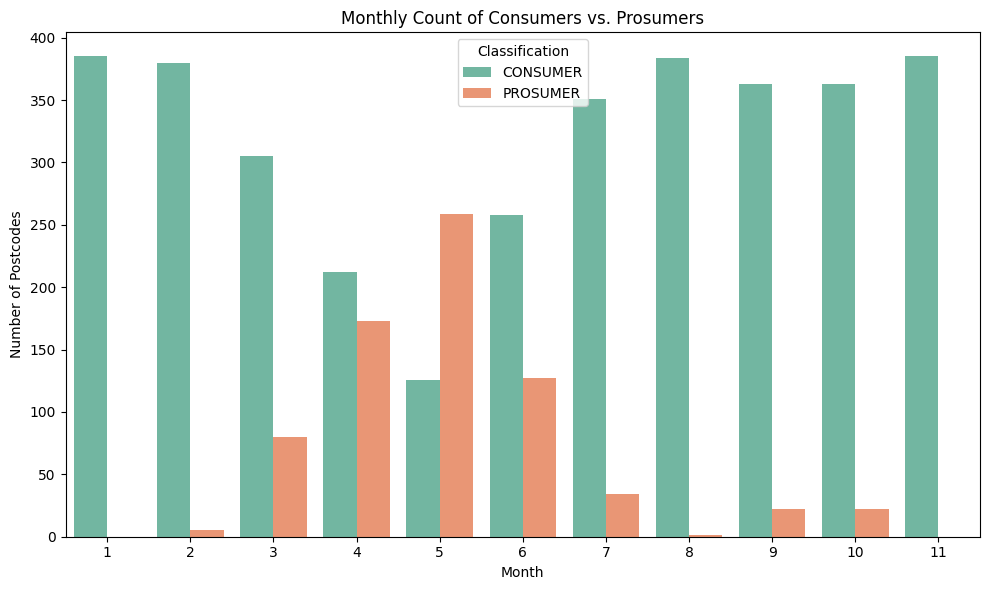

In [ ]:
import geopandas as gpd 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

gdf = gpd.read_file(r"postcode_solar_panels_building_count.shp")

panel_capacity_kwp = 0.37
performance_ratio = 0.85 

results = []
# Data cleaning 
gdf['Gemiddel_2'] = pd.to_numeric(gdf['Gemiddel_2'], errors='coerce')
gdf['Solar_Coun'] = pd.to_numeric(gdf['Solar_Coun'], errors='coerce')
# missing_data = postcodes[postcodes['Gemiddel_2'].isna()]
gdf = gdf.dropna(subset=['Gemiddel_2'])
## Fill missing values for 'solar_panels' with 0
gdf['Solar_Coun'] = gdf['Solar_Coun'].fillna(0)
# postcodes['TotalEnergy'] = postcodes['Gemiddel_2'] * postcodes['Building_C']

for idx, row in gdf.iterrows():
    postcode = row['PC6']
    annual_household_consumption = float(row['Gemiddel_2'])
    building_count = row['Building_C']
    solar_panels = row['Solar_Coun']
    
    total_annual_consumption = annual_household_consumption * building_count 
    installed_capacity_kwp = solar_panels * panel_capacity_kwp
    
    monthly_consumption = [total_annual_consumption * x for x in monthly_consumption_factor]
    monthly_production = [installed_capacity_kwp * factor * 960 for factor in monthly_solar_factor]

    for month, (con, pro) in enumerate(zip(monthly_consumption, monthly_production), start=1):
        net_load = con - pro
        classification = "PROSUMER" if net_load < 0 else "CONSUMER"
        results.append({
            "Postcode":postcode,
            "Month":month, 
            "Consumption_kwh":con, 
            "Production":pro, 
            "Net_load_kwh": net_load, 
            "Classification":classification
        })
results_df = pd.DataFrame(results)
results_df.to_csv(r"Seasonal_classification.csv", index=False)
summary = results_df.groupby("Classification").size()
print(summary)
plt.figure(figsize=(10, 6))
sns.countplot(x="Month", hue="Classification", data=results_df, palette="Set2")
plt.title("Monthly Count of Consumers vs. Prosumers")
plt.ylabel("Number of Postcodes")
plt.xlabel("Month")
plt.legend(title="Classification")
plt.tight_layout()
plt.savefig("monthly_classification_counts.png")
plt.show()

#### Mapping seasonal variations(webmap)

In [ ]:
import geopandas as gpd
import pandas as pd
import folium
from folium import FeatureGroup

# Loading shapefile (refer P2Ptrading.ipynb)
gdf = gpd.read_file(r"postcode_solar_panels_building_count.shp")

# Load seasonal classification results
results_df = pd.read_csv(r"Seasonal_classification.csv")

# Create a classification based on net load level; net load kwh for three months
def classify_level(net_load):
    if net_load > 5000:
        return "Heavy Consumer"
    elif net_load > 0:
        return "Moderate Consumer"
    elif net_load > -5000:
        return "Moderate Prosumer"
    else:
        return "Heavy Prosumer"

# Only aggregate numeric columns, avoiding duplication of columns like 'Month'
numeric_columns = [col for col in results_df.select_dtypes(include='number').columns if col not in ['Month']]

# Add classification levels to results, averaging values by postcode and month
grouped = results_df.groupby(['Postcode', 'Month'])[numeric_columns].mean().reset_index()
grouped['Level'] = grouped['Net_load_kwh'].apply(classify_level)

# Create separate GeoDataFrames per season
season_months = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11]
}

# Create folium map
m = folium.Map(location=[52.52, 6.1], zoom_start=12)

levels_colors = {
    "Heavy Consumer": "darkred",
    "Moderate Consumer": "orange",
    "Moderate Prosumer": "lightblue",
    "Heavy Prosumer": "darkblue"
}

def add_season_layer(season, months):
    season_data = grouped[grouped['Month'].isin(months)].groupby('Postcode')[numeric_columns].mean().reset_index()
    season_data['Level'] = season_data['Net_load_kwh'].apply(classify_level)
    merged = gdf.merge(season_data[['Postcode', 'Level']], left_on='PC6', right_on='Postcode', how='left')
    
    geojson = folium.GeoJson(
        merged,
        style_function=lambda feature: {
            'fillColor': levels_colors.get(feature['properties']['Level'], 'gray'),
            'color': 'black',
            'weight': 0.5,
            'fillOpacity': 0.6
        },
        tooltip=folium.GeoJsonTooltip(fields=['PC6', 'Level'], aliases=['Postcode:', 'Level:'])
    )

    fg = FeatureGroup(name=season)
    geojson.add_to(fg)
    fg.add_to(m)

for season, months in season_months.items():
    add_season_layer(season, months)

folium.LayerControl(collapsed=False).add_to(m)
m.save("seasonal_postcode_consumer_prosumer_map.html")